In [2]:
import os, re
from dotenv import dotenv_values

from sqlalchemy import create_engine, text

from datetime import date,datetime,timedelta
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import requests

# Stations, Nitrates and Weather Data

In [3]:
# Settings from .env file

settings = dotenv_values()

# SQL CONFIG

settings = dotenv_values() # Loads settings from .env file
ROOT='..' # relative path to the root of the project

db_uri = (
    f"mysql+pymysql://{settings['SQL_USER']}:{settings['SQL_PWD']}"
    f"@{settings['SQL_HOST']}/{settings['SQL_DB']}"
    f"?ssl_ca={os.path.join(ROOT,settings['SQL_SSL_CA'])}"
    f"&ssl_cert={os.path.join(ROOT,settings['SQL_SSL_CERT'])}"
    f"&ssl_key={os.path.join(ROOT,settings['SQL_SSL_KEY'])}"
    f"&ssl_check_hostname=false"
)

engine = create_engine(db_uri,echo=False, future=False)

In [4]:
# Stations Dataframe

stations = pd.read_csv('../data/stations.csv')
stations.head()

,station_id,label,alt,river_id,river_label,mean_nitrate,lat,lon
0,6000990,BELRUPT,292,U---0000,La Saône,4.513699,48.090273,6.101941
1,6000998,MONTHUREUX-SUR-SAONE 2,241,U---0000,La Saône,6.428571,48.018251,5.941492
2,6000993,JONVELLE,230,U---0000,La Saône,9.433333,47.936380,5.923536
3,6001000,CENDRECOURT,213,U---0000,La Saône,9.233333,47.840261,5.917378
4,6003600,SCEY-SUR-SAONE-ET-ST-ALBI,210,U---0000,La Saône,8.421519,47.661731,5.972460


In [5]:
# weather dataframe

query = "SELECT * FROM weather ;"
weather = pd.read_sql_query(query,engine)
weather.day = pd.to_datetime(weather.day)
weather.head()

,day,station_id,temperature,precipitation,maxwind,description
0,2010-01-01,6000990,2.4,3.9,20.2,Heavy snow
1,2010-01-01,6000993,2.4,7.6,20.9,Heavy snow
2,2010-01-01,6000998,2.4,7.6,20.9,Heavy snow
3,2010-01-01,6001000,3.1,7.3,21.2,Heavy snow
4,2010-01-01,6002500,3.1,7.3,21.2,Heavy snow


In [6]:
# nitrates dataframe
nitrates = pd.read_csv('../data/nitrates_2011_2021.csv')
nitrates.day = pd.to_datetime(nitrates.day)
nitrates.head()

,station_id,day,measure
0,6000990,2011-01-19,4.5
1,6000990,2011-03-23,3.5
2,6000990,2011-05-17,4.7
3,6000990,2011-07-20,4.1
4,6000990,2011-09-21,4.5


# Features Constitution 

In [7]:
DELTA = 60

In [8]:
df = nitrates.copy()

In [9]:
# We add mean_nitrate to the df
mean_nitrate = stations[['station_id','mean_nitrate']]
df = pd.merge(df,mean_nitrate,how='inner',on='station_id')

In [10]:
# We add precipitations to the df
precipitations = weather[['station_id','day','precipitation']]
df = pd.merge(df,precipitations,how='inner',on=['station_id','day'])

# We add previous days precipitation
for delta in range(1,DELTA) :
    previous_prec = weather[['station_id','day','precipitation']].copy()
    previous_prec['day'] = previous_prec['day'] + timedelta(delta)
    previous_prec.columns = ['station_id','day',f'precipitation_{delta}']
    df = pd.merge(df,previous_prec,how='inner',on=['station_id','day'])

In [11]:
# We add temperature
temp = weather[['station_id','day','temperature']]
df = pd.merge(df,temp,how='inner',on=['station_id','day'])

# We add previous days temperature
for delta in range(1,DELTA) :
    previous_temp = weather[['station_id','day','temperature']].copy()
    previous_temp['day'] = previous_temp['day'] + timedelta(delta)
    previous_temp.columns = ['station_id','day',f'temperature_{delta}']
    df = pd.merge(df,previous_temp,how='inner',on=['station_id','day'])

In [12]:
# We add maxwind
maxwind = weather[['station_id','day','maxwind']]
df = pd.merge(df,maxwind,how='inner',on=['station_id','day'])

# We add previous days precipitation
for delta in range(1,DELTA) :
    previous_mw = weather[['station_id','day','maxwind']].copy()
    previous_mw['day'] = previous_mw['day'] + timedelta(delta)
    previous_mw.columns = ['station_id','day',f'maxwind_{delta}']
    df = pd.merge(df,previous_mw,how='inner',on=['station_id','day'])

In [13]:
# We add day_of_year
# Format date
df['doy'] = df['day'].dt.dayofyear # doy = day of year

# Turns day of year to cyclical feature (sin,cos)
df['sin_doy'] = np.sin( (df['doy']-1) * 2 * np.pi / 365 )
df['cos_doy'] = np.cos( (df['doy']-1) * 2 * np.pi / 365 )

constituted_df = df.copy()

/tmp/ipykernel_55560/2786146164.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['doy'] = df['day'].dt.dayofyear # doy = day of year
/tmp/ipykernel_55560/2786146164.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sin_doy'] = np.sin( (df['doy']-1) * 2 * np.pi / 365 )
/tmp/ipykernel_55560/2786146164.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

# NN Model

In [25]:
from tensorflow.keras import models, layers, regularizers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.layers.experimental.preprocessing import Normalization

In [15]:
feat_cols = [
    'mean_nitrate',
    'precipitation',
    'temperature',
    'maxwind',
    'sin_doy',
    'cos_doy',
]

DELTA_M = 60
if DELTA_M > DELTA : DELTA_M = DELTA

for delta in range(1,DELTA_M) :
    feat_cols += [f'precipitation_{delta}']
for delta in range(1,DELTA_M) :
    feat_cols += [f'temperature_{delta}']
for delta in range(1,DELTA_M) :
    feat_cols += [f'maxwind_{delta}']

In [16]:
df = constituted_df.copy()

# Retreiving Validation Data
VAL_STATION = 6045800 # 6059500
val_rows = (df['station_id'] == VAL_STATION) & (df['day'] > datetime(year=2016,month=1,day=1))

df_val = df[val_rows].copy()
df = df[df['station_id'] != VAL_STATION].copy()
X_val = df_val[feat_cols]
y_val=df_val['measure']

# Features, Target
X = df[feat_cols]
y = df['measure']

# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


In [22]:
def init_model(X_train):
    
    normalizer = Normalization()
    normalizer.adapt(X_train)
    
    regl2 = regularizers.L2(0.001)
    
    model = models.Sequential()
    
    model.add(normalizer)
    
    model.add( layers.Dense(200,activation='relu',input_dim=X_train.shape[1]) )
    model.add( layers.Dropout(rate=0.2) )
    model.add( layers.Dense(100,activation='relu',kernel_regularizer=regl2) )
    model.add(layers.Dropout(rate=0.3))
    
    model.add( layers.Dense(50,activation='relu',kernel_regularizer=regl2) )
    model.add(layers.Dropout(rate=0.5))
    
    
    model.add(layers.Dense(1,activation='linear'))
    
    return model

model = init_model(X_train)
model.compile(loss='mse', optimizer='adam')

es = EarlyStopping(
	patience=15,
	monitor='val_loss',
	restore_best_weights=True
)

history = model.fit(
	X_train,y_train,
	epochs=2000,  # set it to a large value, early stoping will stop the fit
	batch_size=32, # good values : 16 or 32
	callbacks=[es],
	validation_data=(X_test, y_test),
	verbose=0
)

val_loss_min = min(history.history['val_loss'])
print(f'{val_loss_min=}')

val_loss_min=5.214206695556641


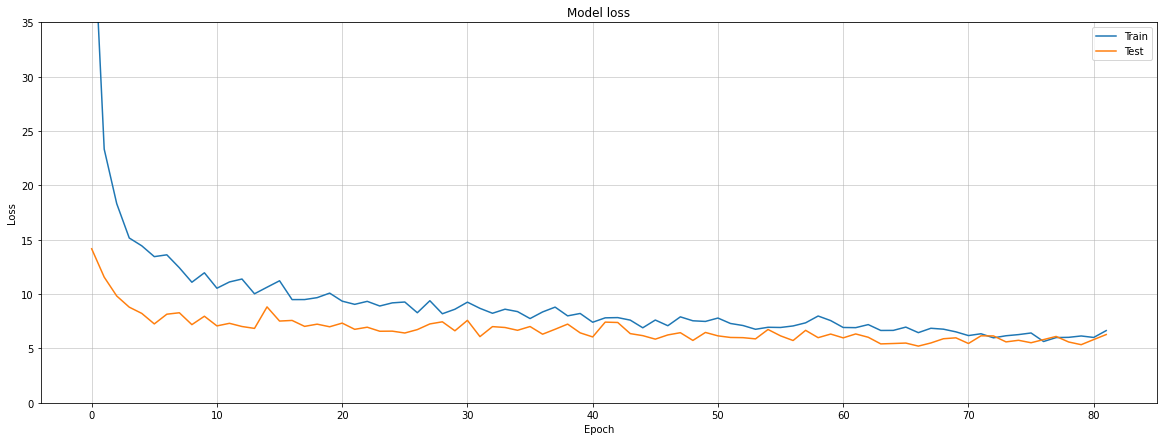

In [23]:
def plot_loss(history, title=None):
    fig = plt.figure(figsize=(20,7))
    
    # --- LOSS --- 
    ax = plt.gca()
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylim((0,35))
    ax.legend(['Train', 'Test'], loc='best')
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)

    if title:
        fig.suptitle(title)

plot_loss(history)

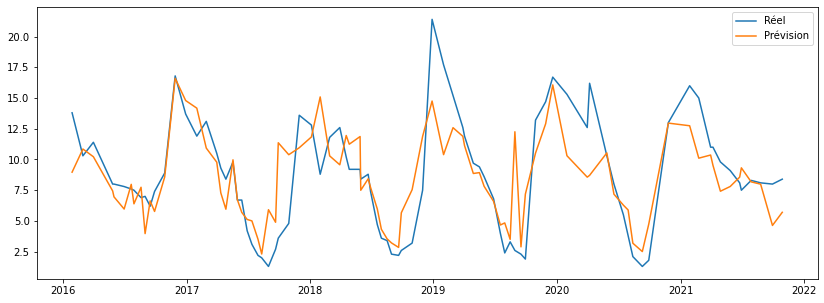

In [24]:
# VAL PLOT
y_pred = model.predict(X_val)
df_val['prediction'] = y_pred

df_val.sort_values('day',inplace=True)

plt.figure(figsize=(14,5))
plt.plot(df_val['day'],df_val['measure'],label='Réel')
plt.plot(df_val['day'],df_val['prediction'],label='Prévision')
plt.legend()
plt.show()